## All new simulations (July 23 . 2025)


Generating random samples over 2-body frustrated model via starting from a VGP, and generating other VGP Hamiltonians via $\Pi_i R_z(\alpha_i)$, with $\alpha_i = \alpha$ for all $i$. 
Do 10 instances of finding different solutions, and generating 20 random rotations over each.

In [1]:
import numpy as np
import scipy.linalg
from scipy.optimize import minimize
from functools import reduce

I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])

def build_op_on_sites(op, N, sites):
    op_list = []
    sites = set(sites)
    for i in range(N):
        if i in sites:
            op_list.append(op)
        else:
            op_list.append(np.eye(2))
    return reduce(np.kron, op_list)

def local_H_block(N, i, j, a, b, c, d):
    base = build_op_on_sites(X, N, [i, j])
    term = np.zeros_like(base, dtype=complex)
    term += 1.0j * b * build_op_on_sites(Z, N, [i]) @ base
    term += 1.0j * c * build_op_on_sites(Z, N, [j]) @ base
    term += d * build_op_on_sites(Z, N, [i, j]) @ base
    return term

def f_H(H):
    H_off = H - np.diag(np.diag(H))
    H_abs = np.abs(H_off)
    return np.trace(scipy.linalg.expm(H_abs)) - np.trace(scipy.linalg.expm(-H_off))

def get_edges(Lx, Ly):
    N = Lx * Ly
    edges = []
    edge_types = []
    def idx(x, y): return y * Lx + x
    # Horizontal
    for y in range(Ly):
        for x in range(Lx-1):
            edges.append((idx(x, y), idx(x+1, y)))
            edge_types.append(0)
    # Vertical
    for y in range(Ly-1):
        for x in range(Lx):
            edges.append((idx(x, y), idx(x, y+1)))
            edge_types.append(1)
    # -45 diagonal
    for y in range(Ly-1):
        for x in range(Lx-1):
            edges.append((idx(x, y), idx(x+1, y+1)))
            edge_types.append(2)
    # +45 diagonal
    for y in range(1, Ly):
        for x in range(Lx-1):
            edges.append((idx(x, y), idx(x+1, y-1)))
            edge_types.append(3)
    return edges, edge_types

def build_H(params, Lx, Ly):
    params = np.asarray(params).reshape(4, 4)  # ensure 4x4
    N = Lx * Ly
    H = np.zeros((2**N, 2**N), dtype=complex)
    edges, edge_types = get_edges(Lx, Ly)
    for (i, j), e_type in zip(edges, edge_types):
        # This line will now always work!
        a, b, c, d = params[e_type]
        H += local_H_block(N, i, j, a, b, -b, d)
    return H

# Lattice size
Lx, Ly = 2, 2
def penalty(coeff_blocks, base_thresh=0.1, end_thresh=0.25, penalty_scale=5):
    pen = 0.0
    # Block 0 (A) penalty (stricter)
    s0 = sum(x**2 for x in coeff_blocks[0])
    if s0 < end_thresh:
        pen += penalty_scale * (end_thresh - s0)**2
    # Block 3 (D) penalty (stricter)
    s3 = sum(x**2 for x in coeff_blocks[3])
    if s3 < end_thresh:
        pen += penalty_scale * (end_thresh - s3)**2
    # All blocks (so they don't go to zero)
    for c in coeff_blocks:
        s = sum(x**2 for x in c)
        if s < base_thresh:
            pen += penalty_scale * (base_thresh - s)**2
    return pen

def abs_min_penalty(params, min_val=0.1, penalty_scale=1e5):
    penalty = 0.0
    for p in params:
        if abs(p) < min_val:
            penalty += penalty_scale * (min_val - abs(p))**2
    return penalty

def objective(params):
    params_mat = np.asarray(params).reshape(4, 4)
    H = build_H(params_mat, Lx=Lx, Ly=Ly)
    val = f_H(H).real
    val += abs_min_penalty(params, min_val=0.1, penalty_scale=2.0)
    val += penalty(params_mat)  # your existing block penalty
    return val

# Callback to print progress
def callback(params):
    H = build_H(params, Lx, Ly)
    fval = f_H(H).real
    print(f"Current f_H = {fval}")



## Performing the optimization on the $2 \times 2$ lattice and finding 'optimal' non-zero parameters

In [2]:
random_steps = 10  # Defines the number of initial random starting points .. We take the best parameters over many random initializations
best_cost = 100
best_params = []
for step in range(random_steps):
    # Initial guess
    x0 = np.zeros((4, 4))
    for i in range(4):
        # Pick a random nonzero a (make it noticeably larger)
        a = np.random.uniform(0.1, 0.75) * np.random.choice([-1, 1])
        # Pick b, c ~ moderate random
        b = np.random.uniform(-1.0, 1.0)
        c = -b
        # Pick d with strictly smaller magnitude than a
        d = np.random.uniform(-abs(a), abs(a))
        x0[i] = [a, b, c, d]

    x0 = x0.flatten()
    # Run optimizer until f_H ~ 0
    result = minimize(
        objective,
        x0,
        tol=1e-12,
        options={'maxiter': 1000, 'disp': True},
        callback=callback
    )

    params_opt = result.x
    H_opt = build_H(params_opt, Lx, Ly)
    final_f_H = f_H(H_opt).real

    if final_f_H < best_cost:
        best_cost = final_f_H
        best_params = params_opt

print("\n--- Optimization Result ---")
print("Optimal parameters (reshaped):")
print(best_params.reshape(4, 4))
print(f"Final f_H = {best_cost}")

Current f_H = 1.8539447171090728
Current f_H = 0.3899771144866655
Current f_H = 0.11102400488530506
Current f_H = 0.070599366808203
Current f_H = 0.03841213664742682
Current f_H = 0.024437999282231004
Current f_H = 0.023442151518363374
Current f_H = 0.01987073498666092
Current f_H = 0.016990467607179482
Current f_H = 0.011093632708956136
Current f_H = 0.010894205740576979
Current f_H = 0.01091893413104117
Current f_H = 0.010638204327300116
Current f_H = 0.01011476791833843
Current f_H = 0.009191847518096097
Current f_H = 0.00914006012956392
Current f_H = 0.009010814900040742
Current f_H = 0.008739295039799089
Current f_H = 0.00865503413338331
Current f_H = 0.00893818510491684
Current f_H = 0.009615284664235446
Current f_H = 0.010255026616441398
Current f_H = 0.011025911113563325
Current f_H = 0.010996319328164361
Current f_H = 0.011007991182022892
Current f_H = 0.009604669070114369
Current f_H = 0.009585046837873534
Current f_H = 0.010327217421817636
Current f_H = 0.009001778741467348


/opt/homebrew/anaconda3/lib/python3.12/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.049772
         Iterations: 95
         Function evaluations: 3769
         Gradient evaluations: 221
Current f_H = 6.050007108613002
Current f_H = 1.9984081895966312
Current f_H = 1.7427012418703498
Current f_H = 1.0555600309009847
Current f_H = 0.9464042697563926
Current f_H = 0.7339236627366788
Current f_H = 0.5713919231962912
Current f_H = 0.2976216787819048
Current f_H = 0.1655978411808512
Current f_H = 0.1406357290741198
Current f_H = 0.08044430490131305
Current f_H = 0.06423544086928246
Current f_H = 0.06300833813097384
Current f_H = 0.06233899605851434
Current f_H = 0.05641998048530894
Current f_H = 0.045866060847423284
Current f_H = 0.03153490526956659
Current f_H = 0.021551949219272615
Current f_H = 0.012371546846075887
Current f_H = 0.009747233689346047
Current f_H = 0.009292037281198873
Current f_H = 0.008516611680896347
Current f_H = 0.008749656744058143
Current f_H = 0.009034055638878158
Current f_H = 0.009352952508820067
Current f_H = 0

/opt/homebrew/anaconda3/lib/python3.12/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.048198
         Iterations: 107
         Function evaluations: 3684
         Gradient evaluations: 216
Current f_H = 7.5685697119522715
Current f_H = 2.4056053751057505
Current f_H = 1.5356472141404396
Current f_H = 0.6219729804740979
Current f_H = 0.19069123853992664
Current f_H = 0.1476015933752315
Current f_H = 0.06515406710634153
Current f_H = 0.04851324251391986
Current f_H = 0.026836092719740634
Current f_H = 0.00844922259629044
Current f_H = 0.006262136990443423
Current f_H = 0.0049920806630048276
Current f_H = 0.004625395336113058
Current f_H = 0.004696900293282624
Current f_H = 0.005038221994674075
Current f_H = 0.005615579439854912
Current f_H = 0.007343440850956284
Current f_H = 0.00640022021997666
Current f_H = 0.005524060112520601
Current f_H = 0.004513657374182856
Current f_H = 0.0026820749090461504
Current f_H = 0.004524710224163897
Current f_H = 0.00606548953777164
Current f_H = 0.0038324349175447026
Current f_H = 0.0019419329677212716

/opt/homebrew/anaconda3/lib/python3.12/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.040000
         Iterations: 59
         Function evaluations: 2528
         Gradient evaluations: 148
Current f_H = 0.8753584598897675
Current f_H = 0.0402523361905196
Current f_H = 0.03658737867544204
Current f_H = 0.030660593024620653
Current f_H = 0.016178804588250273
Current f_H = 0.010694747273802818
Current f_H = 0.009449879653164572
Current f_H = 0.009916046782141308
Current f_H = 0.010341639530814462
Current f_H = 0.011465752160919607
Current f_H = 0.012056795850391211
Current f_H = 0.010825322884741695
Current f_H = 0.010574836326920689
Current f_H = 0.006341347749046378
Current f_H = 0.0056977700083287175
Current f_H = 0.004657485842550102
Current f_H = 0.004274649325914481
Current f_H = 0.00411134240505362
Current f_H = 0.0040724973524106645
Current f_H = 0.004213684272500018
Current f_H = 0.0048037958434790085
Current f_H = 0.0061900564532351154
Current f_H = 0.006529206363698137
Current f_H = 0.006864670444869603
Current f_H = 0.006904607

/opt/homebrew/anaconda3/lib/python3.12/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.048198
         Iterations: 61
         Function evaluations: 2885
         Gradient evaluations: 169
Current f_H = 16.030444619223985
Current f_H = 10.26315543231626
Current f_H = 5.210297533330795
Current f_H = 1.9961228396264659
Current f_H = 1.3051737951183355
Current f_H = 1.2681043166374835
Current f_H = 1.1031238724373154
Current f_H = 0.6252500753639296
Current f_H = 0.5138046230178759
Current f_H = 0.40150431723870383
Current f_H = 0.3959700171415079
Current f_H = 0.30918954620712213
Current f_H = 0.15588910815301915
Current f_H = 0.09085703094558539
Current f_H = 0.0756927550448836
Current f_H = 0.07284792352967884
Current f_H = 0.052418256234460614
Current f_H = 0.04235721468768361
Current f_H = 0.031270605143333796
Current f_H = 0.020684855178416228
Current f_H = 0.013284188144766063
Current f_H = 0.013287222314517066
Current f_H = 0.011099029590539544
Current f_H = 0.009402690573168115
Current f_H = 0.008553295403245897
Current f_H = 0.00

/opt/homebrew/anaconda3/lib/python3.12/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.040000
         Iterations: 225
         Function evaluations: 6589
         Gradient evaluations: 387
Current f_H = 1.483615802264545
Current f_H = 0.09102628987448114
Current f_H = 0.06769300600083028
Current f_H = 0.046797397036620225
Current f_H = 0.0191936688428882
Current f_H = 0.01655867887205531
Current f_H = 0.010107830294337816
Current f_H = 0.009094284229377081
Current f_H = 0.006786432122893871
Current f_H = 0.00655219653164707
Current f_H = 0.0064652653839090135
Current f_H = 0.006523375791267938
Current f_H = 0.006702585912044867
Current f_H = 0.00710822805144673
Current f_H = 0.007268436829370728
Current f_H = 0.007801842383585722
Current f_H = 0.008114378201547368
Current f_H = 0.008747212976484064
Current f_H = 0.009529388175600673
Current f_H = 0.010736422729159756
Current f_H = 0.010615693442762364
Current f_H = 0.010379552536878833
Current f_H = 0.01001223619826419
Current f_H = 0.009466641344282323
Current f_H = 0.0090390728355487

/opt/homebrew/anaconda3/lib/python3.12/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.053272
         Iterations: 40
         Function evaluations: 1915
         Gradient evaluations: 112
Current f_H = 1.5596989038221416
Current f_H = 0.6662887531963584
Current f_H = 0.4519846797909892
Current f_H = 0.18472652008897228
Current f_H = 0.1733462698592021
Current f_H = 0.13622990285978176
Current f_H = 0.0825570546881309
Current f_H = 0.05638123384797922
Current f_H = 0.0286663006708352
Current f_H = 0.004534392796855968
Current f_H = 0.004549981674326631
Current f_H = 0.004853957689398669
Current f_H = 0.005332003109902672
Current f_H = 0.004590921114939306
Current f_H = 0.0025817433587782546
Current f_H = 0.0015587079147465488
Current f_H = 0.0012623639565454425
Current f_H = 0.0011112588670272316
Current f_H = 0.0007749616153418515
Current f_H = 0.0006081298262827772
Current f_H = 0.0006058189786237733
Current f_H = 0.0006037455350025311
Current f_H = 0.0003394134322505238
Current f_H = 0.00025448488291601734
Current f_H = 0.00026079220

/opt/homebrew/anaconda3/lib/python3.12/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.040000
         Iterations: 35
         Function evaluations: 1933
         Gradient evaluations: 113
Current f_H = 27.703107417148765
Current f_H = 3.5352875289380847
Current f_H = 3.1273808656740343
Current f_H = 1.7242241265100375
Current f_H = 1.1939240475079487
Current f_H = 0.9874969168344521
Current f_H = 0.637734401386794
Current f_H = 0.3998166525939837
Current f_H = 0.20283294561105691
Current f_H = 0.1470895529963343
Current f_H = 0.14662667798204154
Current f_H = 0.14495926026015127
Current f_H = 0.14281906703305935
Current f_H = 0.12181132491727453
Current f_H = 0.08014159419466438
Current f_H = 0.01806908872249835
Current f_H = 0.0036246886194817307
Current f_H = 0.003767366242335868
Current f_H = 0.003369260932153395
Current f_H = 0.0026795545909052976
Current f_H = 0.0024252773984585474
Current f_H = 0.0023686088186707366
Current f_H = 0.003230850354420056
Current f_H = 0.005085778285398135
Current f_H = 0.005180467779368314
Current f_

/opt/homebrew/anaconda3/lib/python3.12/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.062577
         Iterations: 46
         Function evaluations: 2953
         Gradient evaluations: 173
Current f_H = 12.617654266202976
Current f_H = 6.145898401609514
Current f_H = 5.870871097180981
Current f_H = 4.398333643697654
Current f_H = 3.3391380527123005
Current f_H = 1.952441735211309
Current f_H = 0.24126243688857585
Current f_H = 0.17694678505563388
Current f_H = 0.08516385243748914
Current f_H = 0.06885936332380993
Current f_H = 0.057324459237804604
Current f_H = 0.053363741537637566
Current f_H = 0.04762997791004864
Current f_H = 0.03974058724423912
Current f_H = 0.026130720440988853
Current f_H = 0.012991129639729593
Current f_H = 0.005782171402870517
Current f_H = 0.002504019671818014
Current f_H = 0.0015809660689143357
Current f_H = 0.001204407917896333
Current f_H = 0.0007794942658705395
Current f_H = 0.0007512723053366699
Current f_H = 0.0007358008569440244
Current f_H = 0.0007385846289764686
Current f_H = 0.0007772862377350975
Curr

/opt/homebrew/anaconda3/lib/python3.12/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.040000
         Iterations: 79
         Function evaluations: 3683
         Gradient evaluations: 216
Current f_H = 2.010711822878534
Current f_H = 0.3447562257747627
Current f_H = 0.3155272087288168
Current f_H = 0.2671510765599834
Current f_H = 0.17668174674048132
Current f_H = 0.10977246825077458
Current f_H = 0.05749314943336259
Current f_H = 0.031595664323557315
Current f_H = 0.02318289932971851
Current f_H = 0.013998645850399782
Current f_H = 0.007157094816570009
Current f_H = 0.005041248451554736
Current f_H = 0.0006360285667383891
Current f_H = 0.0007565212933755561
Current f_H = 0.0006456937156684717
Current f_H = 0.0002916363371383568
Current f_H = 0.00029477862815951994
Current f_H = 0.00021961728895547594
Current f_H = 0.00014958665896003254
Current f_H = 0.00012677310348863102
Current f_H = 8.249392727321947e-05
Current f_H = 2.2651128908535156e-05
Current f_H = 1.4544561750540197e-06
Current f_H = 1.204460389203632e-06
Current f_H = 9.60

/opt/homebrew/anaconda3/lib/python3.12/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


### Verifying VGP of the optimal parameters hold for larger lattice

In [3]:

sizes = [(2,2) , (2,3) , (3,2) , (2,4) , (3,3) , (2,5)]
best_params = best_params.reshape(4, 4) 
print(f'The parameters are {best_params} with cost {best_cost}')
print(' ')
for (Lx , Ly) in sizes:
    H = build_H(best_params, Lx, Ly)
    print(f'The cost for ({Lx} x {Ly}) lattice is {f_H(H)}')

The parameters are [[ 5.79058656e-01 -5.43004366e-09 -2.80511808e-01  1.47481210e-08]
 [ 6.83650148e-01  3.36079144e-01 -8.30662246e-01  3.40647301e-01]
 [ 6.79907185e-01  1.07351275e-01  4.86295147e-01  1.08854513e-01]
 [ 2.04286910e-01 -9.99793744e-02  5.66340711e-01  1.01311208e-01]] with cost 4.256168395500026e-08
 
The cost for (2 x 2) lattice is (4.256168395500026e-08+1.8394517332317548e-16j)
The cost for (2 x 3) lattice is (4.389133095763327+2.833172239972395e-15j)
The cost for (3 x 2) lattice is (4.2198314531560754e-07+1.2605520501279455e-15j)
The cost for (2 x 4) lattice is (54.79923398923734+4.813726087508219e-16j)
The cost for (3 x 3) lattice is (98.20051217430819-3.6292260931971475e-15j)
The cost for (2 x 5) lattice is (493.13100029184534+1.7747804488687994e-16j)


In [27]:
x0 = np.zeros((4, 4))
for i in range(4):
    # Pick a random nonzero a (make it noticeably larger)
    a = np.random.uniform(0.1, 0.75) * np.random.choice([-1, 1])
    # Pick b, c ~ moderate random
    b = np.random.uniform(-1.0, 1.0)
    c = np.random.uniform(-1.0, 1.0)
    # Pick d with strictly smaller magnitude than a
    d = np.random.uniform(-abs(a), abs(a))
    a -= 100
    print(f'a is {a}')
    x0[i] = [a, b, c, d]

H = build_H(x0, 2, 2)
print(f'The parameters are {x0}')
print(f'The cost for ({2} x {2}) test lattice is {f_H(H)}')

a is -100.54883923475928
a is -100.18170381039016
a is -100.60071393361639
a is -99.31324709438118
The parameters are [[-1.00548839e+02  1.01118147e-01  4.68510224e-01  3.10043681e-02]
 [-1.00181704e+02  1.17876364e-01 -7.30228161e-01  9.45333894e-02]
 [-1.00600714e+02  5.84638603e-01 -9.17626922e-01 -5.72201964e-01]
 [-9.93132471e+01 -2.20802757e-01  1.18235873e-01  5.18774000e-01]]
The cost for (2 x 2) test lattice is (80.53676862308521+2.6011880069608e-15j)


### Verifying that VGPness holds for single spin rotations $\Pi_{i=1}^NR_{Z_i}(\alpha)$ for different instances of random $\alpha$

In [20]:
## Perform Rz rotations on the initial block, retrieve the block and then do

def build_global_z_rotation(N, alpha):
    Z = np.array([[1, 0], [0, -1]])
    Z_sum = sum(build_op_on_sites(Z, N, [i]) for i in range(N))
    U = scipy.linalg.expm(-1j * alpha * Z_sum)
    return U

def trace_overlap(O1, O2):
    # Returns Tr(O1^\dagger O2) / 2^N
    D = float(O1.shape[0])
    return np.trace(O1 @ O2) / (D)

def get_edge_basis_ops(N, i, j):
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    # Four basis ops for (i,j): I, Z_i, Z_j, Z_i Z_j, all times X_i X_j
    Xij = build_op_on_sites(X, N, [i, j])
    bases = []
    # 1. I * X_i X_j
    bases.append(Xij)
    # 2. Z_i * X_i X_j
    bases.append(build_op_on_sites(Z, N, [i]) @ Xij)
    # 3. Z_j * X_i X_j
    bases.append(build_op_on_sites(Z, N, [j]) @ Xij)
    # 4. Z_i Z_j * X_i X_j
    bases.append(build_op_on_sites(Z, N, [i, j]) @ Xij)
    return bases

# The following function performs an RZ(2*alpha) on all spins
def extract_new_params(params, alpha):
    # Build original Hamiltonian
    Lx , Ly = 2 , 2
    N = Lx * Ly
    H = build_H(params, Lx, Ly)
    U = build_global_z_rotation(N, alpha)
    H_new = U @ H @ U.conj().T
    edges, edge_types = get_edges(Lx , Ly)
    new_params = []
    for idx, (i, j) in enumerate(edges):
        # For each fundamental block, only take the first instance of each edge type (block)
        if idx >= 4: break
        basis_ops = get_edge_basis_ops(N, i, j)
        coeffs = [trace_overlap(H_new, Q) for Q in basis_ops]
        new_params.append(coeffs)
        #print(f"Edge {i}-{j} new coeffs: {np.round(coeffs, 6)}")
    return np.array(new_params)

def run_alpha_ensemble(params_init, random_instances=20):
    sizes = [(2,2), (2,3), (2,4), (3,3), (2,5)]
    results = []
    alpha = np.random.uniform(0, 2*np.pi)
    # Always extract block params using a 2x2 system
    block_params = extract_new_params(params_init, alpha)
    for (Lx, Ly) in sizes:
        N = Lx * Ly
        f_H_list = []
        for _ in range(random_instances):
            # Tile the block params for the larger system (assume periodic or simply tile block params by edge_type)
            def tiled_params(Lx, Ly):
                params_arr = np.zeros((4, 4))
                for k in range(4):
                    params_arr[k, :] = block_params[k]
                return params_arr
            # Build H for current lattice
            params_for_lattice = tiled_params(Lx, Ly)
            H = build_H(params_for_lattice, Lx, Ly)
            fH_val = f_H(H).real
            f_H_list.append(fH_val)
        avg_f_H = np.mean(f_H_list)
        print(f"Lx={Lx}, Ly={Ly}, N={N} --> avg f_H = {avg_f_H:.6f}")
        results.append((N, avg_f_H))
    return results

In [21]:
# Perform 20 instances of random rotations and plot the average
results = run_alpha_ensemble(best_params, random_instances=20)

/var/folders/y7/l21gv11s0fl71s2rjkzl_w1r0000gn/T/ipykernel_10997/2308774000.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
  params_arr[k, :] = block_params[k]


Lx=2, Ly=2, N=4 --> avg f_H = 0.000000
Lx=2, Ly=3, N=6 --> avg f_H = 0.000000
Lx=2, Ly=4, N=8 --> avg f_H = 0.000000
Lx=3, Ly=3, N=9 --> avg f_H = 0.000000
Lx=2, Ly=5, N=10 --> avg f_H = 0.000000


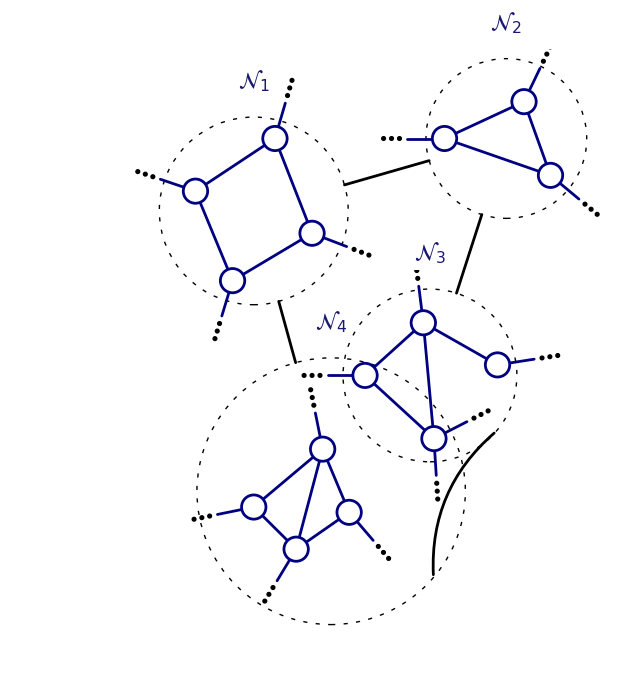

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

def draw_cluster_circle(ax, node_indices, label, node_pos, radius_buffer=0.35, label_offset=(0, 0.55)):
    nodes = np.array([node_pos[i] for i in node_indices])
    center = nodes.mean(axis=0)
    distances = np.linalg.norm(nodes - center, axis=1)
    radius = distances.max() + radius_buffer
    circ = plt.Circle(
        center, radius, fill=False,
        linestyle=(0, (3, 6)),  # Short dash, spaced out
        edgecolor='black', linewidth=1.0, zorder=0  # Thinner
    )
    ax.add_patch(circ)
    ax.text(center[0] + label_offset[0], center[1] + radius + label_offset[1], label,
            fontsize=16, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=1.0),
            color='midnightblue', ha='center', zorder=20)

def draw_dangling_edges_with_dots(ax, cluster_nodes, node_pos, length=0.7, dots_spacing=0.15, dot_radius=0.035, color='navy'):
    nodes = np.array([node_pos[i] for i in cluster_nodes])
    center = nodes.mean(axis=0)
    for i in cluster_nodes:
        pos = np.array(node_pos[i])
        vec = pos - center
        norm = np.linalg.norm(vec)
        if norm == 0:
            continue
        direction = vec / norm
        # End of the main dangling edge
        end = pos + direction * length
        ax.plot([pos[0], end[0]], [pos[1], end[1]], color=color, lw=2, solid_capstyle='round')
        # Draw 3 small black dots after the dangling edge, equally spaced
        for k in range(1, 4):
            dot_center = end + direction * (dots_spacing * k)
            dot = plt.Circle(dot_center, dot_radius, color='black', zorder=20)
            ax.add_patch(dot)

def cluster_center_and_radius(node_indices, node_pos, radius_buffer=0.35):
    nodes = np.array([node_pos[i] for i in node_indices])
    center = nodes.mean(axis=0)
    distances = np.linalg.norm(nodes - center, axis=1)
    radius = distances.max() + radius_buffer
    return center, radius

fig, ax = plt.subplots(figsize=(8, 8))
ax.axis('off')

# Node positions, with N1 shifted left by -0.7
node_pos = {
    1: (2-0.7, 9), 2: (3.5-0.7, 10), 3: (4.2-0.7, 8.2), 4: (2.7-0.7, 7.3),
    5: (6, 10), 6: (7.5, 10.7), 7: (8, 9.3),
    8: (4.5, 5.5), 9: (5.6, 6.5), 10: (7.0, 5.7), 11: (5.8, 4.3),
    12: (2.4, 3), 13: (3.2, 2.2), 14: (4.2, 2.9), 15: (3.7, 4.1)
}

edges = [
    (1,2),(2,3),(3,4),(4,1),
    (5,6),(6,7),(7,5),
    (8,9),(9,10),(11,8),(9,11),
    (12,13),(13,14),(14,15),(15,12),(13,15),
]

# Draw all internal edges
for i, j in edges:
    x = [node_pos[i][0], node_pos[j][0]]
    y = [node_pos[i][1], node_pos[j][1]]
    ax.plot(x, y, color='navy', lw=2)

# Draw nodes
for i, (x, y) in node_pos.items():
    circle = plt.Circle((x, y), 0.23, edgecolor='navy', facecolor='white', linewidth=2, zorder=10)
    ax.add_patch(circle)

# Cluster definitions
N1_nodes = [1, 2, 3, 4]
N2_nodes = [5, 6, 7]
N3_nodes = [8, 9, 10, 11]
N4_nodes = [12, 13, 14, 15, 11]

# Draw dangling edges with dots for each cluster
draw_dangling_edges_with_dots(ax, N1_nodes, node_pos)
draw_dangling_edges_with_dots(ax, N2_nodes, node_pos)
draw_dangling_edges_with_dots(ax, N3_nodes, node_pos)
draw_dangling_edges_with_dots(ax, N4_nodes, node_pos)

# Get centers and radii for inter-cluster lines
N1_center, N1_radius = cluster_center_and_radius(N1_nodes, node_pos)
N2_center, N2_radius = cluster_center_and_radius(N2_nodes, node_pos)
N3_center, N3_radius = cluster_center_and_radius(N3_nodes, node_pos)
N4_center, N4_radius = cluster_center_and_radius(N4_nodes, node_pos)

# Straight lines: N2->N1, N1->N4, N2->N3
def edge_circle_to_circle(src_center, src_radius, tgt_center, tgt_radius):
    direction = tgt_center - src_center
    length = np.linalg.norm(direction)
    if length == 0:
        return src_center, tgt_center
    direction = direction / length
    start = src_center + direction * src_radius
    end = tgt_center - direction * tgt_radius
    return start, end

# N2 -> N1
start, end = edge_circle_to_circle(N2_center, N2_radius, N1_center, N1_radius)
ax.plot([start[0], end[0]], [start[1], end[1]], color='black', lw=2, zorder=5, solid_capstyle='round')
# N1 -> N4
start, end = edge_circle_to_circle(N1_center, N1_radius, N4_center, N4_radius)
ax.plot([start[0], end[0]], [start[1], end[1]], color='black', lw=2, zorder=5, solid_capstyle='round')
# N2 -> N3
start, end = edge_circle_to_circle(N2_center, N2_radius, N3_center, N3_radius)
ax.plot([start[0], end[0]], [start[1], end[1]], color='black', lw=2, zorder=5, solid_capstyle='round')

# Curved line: N4 (bottom right) -> N3 (right side)
vec_N4_to_N3 = N3_center - N4_center
vec_N4_to_N3_unit = vec_N4_to_N3 / np.linalg.norm(vec_N4_to_N3)
# Start at bottom right of N4 (from center in the direction of N4_to_N3, but adjust downward as well)
angle = np.arctan2(vec_N4_to_N3_unit[1], vec_N4_to_N3_unit[0])
# Add a downward and right component for the "bottom right"
offset_angle = angle - np.pi / 2.0  # adjust this angle for more/less downward
start = N4_center + np.array([np.cos(offset_angle), np.sin(offset_angle)]) * N4_radius

theta = np.pi / 2
rot_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])
# End at rightmost of N3: in the direction from N3 center toward N4 center
end = N3_center  -  rot_matrix @ vec_N4_to_N3_unit * N3_radius

# Draw the curved connection from N4 to N3 (start to end, arc rightward)
arrow = FancyArrowPatch(start, end, connectionstyle="arc3,rad=0.25",
                        color="black", lw=2, arrowstyle='-')
ax.add_patch(arrow)

# Draw cluster circles (node 11 in both clusters 3 & 4)
draw_cluster_circle(ax, N1_nodes, r'$\mathcal{N}_1$', node_pos)
draw_cluster_circle(ax, N2_nodes, r'$\mathcal{N}_2$', node_pos)
draw_cluster_circle(ax, N3_nodes, r'$\mathcal{N}_3$', node_pos)
draw_cluster_circle(ax, N4_nodes, r'$\mathcal{N}_4$', node_pos)

# Set limits to ensure all cluster circles and dots are visible
ax.set_xlim(-2.2, 9.5)
ax.set_ylim(0.0, 11.7)

plt.savefig("prb_cluster_graph_final_custom_connections.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()


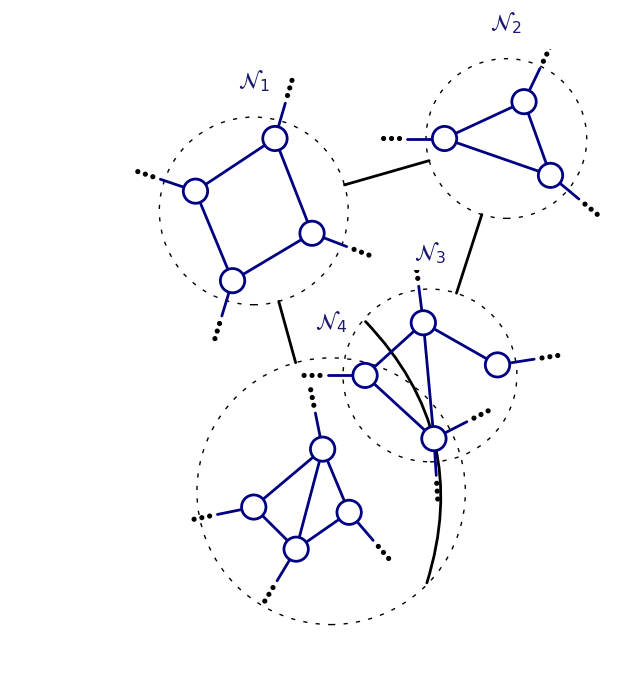

In [42]:
# Here is the full updated script with the corrected curved connection from the bottom-right of N4 
# to the rightmost point of N3 without entering the circles.
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

def draw_cluster_circle(ax, node_indices, label, node_pos, radius_buffer=0.35, label_offset=(0, 0.55)):
    nodes = np.array([node_pos[i] for i in node_indices])
    center = nodes.mean(axis=0)
    distances = np.linalg.norm(nodes - center, axis=1)
    radius = distances.max() + radius_buffer
    circ = plt.Circle(
        center, radius, fill=False,
        linestyle=(0, (3, 6)),  # Short dash, spaced out
        edgecolor='black', linewidth=1.0, zorder=0
    )
    ax.add_patch(circ)
    ax.text(
        center[0] + label_offset[0], center[1] + radius + label_offset[1], label,
        fontsize=16, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=1.0),
        color='midnightblue', ha='center', zorder=20
    )

def draw_dangling_edges_with_dots(ax, cluster_nodes, node_pos, length=0.7, dots_spacing=0.15, dot_radius=0.035, color='navy'):
    nodes = np.array([node_pos[i] for i in cluster_nodes])
    center = nodes.mean(axis=0)
    for i in cluster_nodes:
        pos = np.array(node_pos[i])
        vec = pos - center
        norm = np.linalg.norm(vec)
        if norm == 0:
            continue
        direction = vec / norm
        # Main dangling edge
        end = pos + direction * length
        ax.plot([pos[0], end[0]], [pos[1], end[1]], color=color, lw=2, solid_capstyle='round')
        # Three small dots beyond the edge
        for k in range(1, 4):
            dot_center = end + direction * (dots_spacing * k)
            dot = plt.Circle(dot_center, dot_radius, color='black', zorder=20)
            ax.add_patch(dot)

def cluster_center_and_radius(node_indices, node_pos, radius_buffer=0.35):
    nodes = np.array([node_pos[i] for i in node_indices])
    center = nodes.mean(axis=0)
    distances = np.linalg.norm(nodes - center, axis=1)
    radius = distances.max() + radius_buffer
    return center, radius

fig, ax = plt.subplots(figsize=(8, 8))
ax.axis('off')

# Node positions (N1 shifted left by -0.7)
node_pos = {
    1: (1.3, 9), 2: (2.8, 10), 3: (3.5, 8.2), 4: (2.0, 7.3),
    5: (6, 10), 6: (7.5, 10.7), 7: (8, 9.3),
    8: (4.5, 5.5), 9: (5.6, 6.5), 10: (7.0, 5.7), 11: (5.8, 4.3),
    12: (2.4, 3), 13: (3.2, 2.2), 14: (4.2, 2.9), 15: (3.7, 4.1)
}

edges = [
    (1,2),(2,3),(3,4),(4,1),
    (5,6),(6,7),(7,5),
    (8,9),(9,10),(11,8),(9,11),
    (12,13),(13,14),(14,15),(15,12),(13,15),
]

# Draw internal edges
for i, j in edges:
    x = [node_pos[i][0], node_pos[j][0]]
    y = [node_pos[i][1], node_pos[j][1]]
    ax.plot(x, y, color='navy', lw=2)

# Draw nodes
for i, (x, y) in node_pos.items():
    circle = plt.Circle((x, y), 0.23, edgecolor='navy', facecolor='white', linewidth=2, zorder=10)
    ax.add_patch(circle)

# Cluster definitions
N1_nodes = [1,2,3,4]
N2_nodes = [5,6,7]
N3_nodes = [8,9,10,11]
N4_nodes = [12,13,14,15,11]

# Dangling edges
draw_dangling_edges_with_dots(ax, N1_nodes, node_pos)
draw_dangling_edges_with_dots(ax, N2_nodes, node_pos)
draw_dangling_edges_with_dots(ax, N3_nodes, node_pos)
draw_dangling_edges_with_dots(ax, N4_nodes, node_pos)

# Centers and radii
N1_center, N1_radius = cluster_center_and_radius(N1_nodes, node_pos)
N2_center, N2_radius = cluster_center_and_radius(N2_nodes, node_pos)
N3_center, N3_radius = cluster_center_and_radius(N3_nodes, node_pos)
N4_center, N4_radius = cluster_center_and_radius(N4_nodes, node_pos)

# Straight connections
def line_conn(src_c, src_r, tgt_c, tgt_r):
    v = tgt_c - src_c
    v_u = v/np.linalg.norm(v)
    start = src_c + v_u * src_r
    end = tgt_c - v_u * tgt_r
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', lw=2, zorder=5, solid_capstyle='round')

# N2->N1, N1->N4, N2->N3
line_conn(N2_center, N2_radius, N1_center, N1_radius)
line_conn(N1_center, N1_radius, N4_center, N4_radius)
line_conn(N2_center, N2_radius, N3_center, N3_radius)

# Curved connection N4 bottom-right -> N3 rightmost
# Compute start at bottom-right of N4
diag = np.array([1, -1]); diag_u = diag/np.linalg.norm(diag)
v_N4_to_N3 = N3_center - N4_center
v_rot = np.array([-v_N4_to_N3[1], v_N4_to_N3[0]])   # 90° CCW rotation
v_u_rot = v_rot / np.linalg.norm(v_rot)

# Compute the end point on N3’s circle boundary at this rotated direction
end = N3_center + v_u_rot * N3_radius

# Draw the curved connection (using the previously defined 'start' at N4)
arrow = FancyArrowPatch(start, end,
                        connectionstyle="arc3,rad=0.3",
                        color="black", lw=2, arrowstyle='-')
ax.add_patch(arrow)

# Draw cluster circles and labels
draw_cluster_circle(ax, N1_nodes, r'$\mathcal{N}_1$', node_pos)
draw_cluster_circle(ax, N2_nodes, r'$\mathcal{N}_2$', node_pos)
draw_cluster_circle(ax, N3_nodes, r'$\mathcal{N}_3$', node_pos)
draw_cluster_circle(ax, N4_nodes, r'$\mathcal{N}_4$', node_pos)

# Frame limits
ax.set_xlim(-2.2, 9.5); ax.set_ylim(0.0, 11.7)

plt.savefig("prb_cluster_graph_custom_curve_fixed.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()


# Plotting and generating figures